In [2]:
import numpy as np
import matplotlib.pyplot as plt
from triangle import triangulate, plot as tplot, convex_hull, show_data, get_data
import matplotlib.colors as mcolors
from random import sample
import symfem, sympy

In [6]:
x, y, p1, p2, p3 = sympy.symbols("x, y, p1, p2, p3")
x1, x2, x3, y1, y2, y3 = sympy.symbols("x1:4 y1:4")
triangle_sym = np.array([
    [x1, y1],
    [x2, y2],
    [x3, y3],
    ])
BASIS = symfem.create_element("triangle", "Lagrange", 1)
MAP = BASIS.reference.get_map_to(triangle_sym)
INV_MAP = BASIS.reference.get_inverse_map_to(triangle_sym)

In [3]:
t = np.linspace(0, 2*np.pi, 10, endpoint=False)
points = np.stack((np.cos(t), np.sin(t))).T
seg = np.array([[j, j+1] for j in range(points.shape[0]-1)] + [[points.shape[0] - 1, 0]])

In [4]:
cndt = triangulate({"vertices":points, "segments":seg}, opts="pq30a0.5ne")
points = cndt["vertices"]
triangles = cndt["triangles"]
neighbours = cndt["neighbors"]
triangles_s = points[triangles]

In [5]:
tx = np.linspace(-1, 1, 1000)
ty = np.linspace(-1, 1, 1000)
xx, yy = np.meshgrid(tx, ty, indexing='xy')
points_ = np.stack((xx, yy)).transpose(1, 2, 0)

a = triangles_s[:, 0] - triangles_s[:, 1] 
b = triangles_s[:, 0] - triangles_s[:, 2] 
areas = np.abs(a[:, 0]*b[:, 1] - a[:, 1]*b[:, 0])

In [27]:
a = (points_[...,] - triangles_s[:, 0, None, None])
b = (points_[...,] - triangles_s[:, 1, None, None])
c = (points_[...,] - triangles_s[:, 2, None, None])

area1 = np.abs(a[..., 0] * b[..., 1] - a[..., 1] * b[..., 0])
area2 = np.abs(a[..., 0] * c[..., 1] - a[..., 1] * c[..., 0])
area3 = np.abs(b[..., 0] * c[..., 1] - b[..., 1] * c[..., 0])

indices = np.where(np.isclose((area1+area2+area3).transpose(1, 2, 0), areas[None, None, ...]))

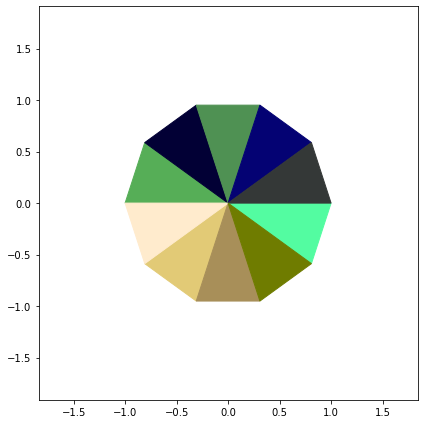

In [28]:
all_colors = list(mcolors.CSS4_COLORS.keys()) + list(mcolors.XKCD_COLORS.keys()) + list(mcolors.BASE_COLORS.keys())
colors = sample(all_colors, triangles_s.shape[0])

%matplotlib inline
fig, ax = plt.subplots(figsize=(6, 6))
ax.axis("equal")

for index, triangle in enumerate(triangles_s[:]):
    t1 = plt.Polygon(triangle[:3], color=colors[index])
    fig.gca().add_patch(t1)
    
ax.set_xlim([points[:, 0].min()-1, points[:, 0].max()+1])
ax.set_ylim([points[:, 1].min()-1, points[:, 1].max()+1])

fig.tight_layout()
plt.tight_layout()

plt.show()

# Linear case

In [42]:
b1 = p1
b2 = p2
b3 = 1-p1-p2

In [47]:
fn_values = np.zeros((points.shape[0], 1))
fn_values[-1] = 1

In [58]:
tx = np.linspace(-1.5, 1.5, 1000)
ty = np.linspace(-1.5, 1.5, 1000)
mx, my = np.meshgrid(tx, ty, indexing="ij")
mz = np.zeros_like(mx)
points_ = np.stack((mx, my)).transpose(1, 2, 0)

for idx, (p_idx, t_points) in enumerate(zip(triangles, triangles_s)):
        
    this_triangle = t_points.copy()
    
    a = this_triangle[0] - this_triangle[1]
    b = this_triangle[0] - this_triangle[2]
    areas = np.abs(a[0]*b[1] - a[1]*b[0])        
    a = (points_[...,] - this_triangle[0, None, None])
    b = (points_[...,] - this_triangle[1, None, None])
    c = (points_[...,] - this_triangle[2, None, None])
    area1 = np.abs(a[..., 0] * b[..., 1] - a[..., 1] * b[..., 0])
    area2 = np.abs(a[..., 0] * c[..., 1] - a[..., 1] * c[..., 0])
    area3 = np.abs(b[..., 0] * c[..., 1] - b[..., 1] * c[..., 0])
    indices = np.where(np.isclose((area1+area2+area3), areas))
    
    resulting_fn = fn_values[p_idx[1]][0] * b1.subs({p1: INV_MAP[0], p2: INV_MAP[1]}) + \
                   fn_values[p_idx[2]][0] * b2.subs({p1: INV_MAP[0], p2: INV_MAP[1]}) + \
                   fn_values[p_idx[0]][0] * b3.subs({p1: INV_MAP[0], p2: INV_MAP[1]})
    
    resulting_fn = resulting_fn.subs({x1:this_triangle[0, 0], x2:this_triangle[1, 0], x3:this_triangle[2, 0], 
                                      y1:this_triangle[0, 1], y2:this_triangle[1, 1], y3:this_triangle[2, 1],})
    
    vals = sympy.lambdify((x, y), resulting_fn)(mx, my)
    
    if isinstance(vals, (int, float)):
        vals = np.ones_like(mz)*vals
        
    mz[indices] = vals[indices]

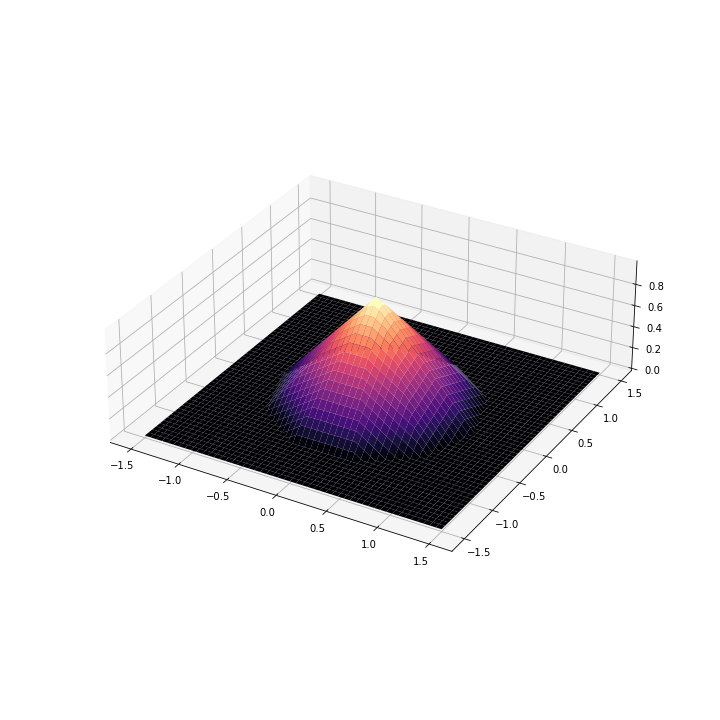

In [59]:
%matplotlib widget
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.plot_surface(mx, my, mz, cmap="magma")
ax.set_box_aspect((np.ptp(mx), np.ptp(my), np.ptp(mz)))
plt.show()

# Quadratic case

In [43]:
t = np.linspace(0, 2*np.pi, 3, endpoint=False)
points = np.stack((np.cos(t), np.sin(t))).T
seg = np.array([[j, j+1] for j in range(points.shape[0]-1)] + [[points.shape[0] - 1, 0]])

In [44]:
cndt = triangulate({"vertices":points, "segments":seg}, opts="pq30a0.5neo2")
points = cndt["vertices"]
triangles = cndt["triangles"]
neighbours = cndt["neighbors"]
triangles_s = points[triangles]

tx = np.linspace(-1, 1, 1000)
ty = np.linspace(-1, 1, 1000)
xx, yy = np.meshgrid(tx, ty, indexing='xy')
points_ = np.stack((xx, yy)).transpose(1, 2, 0)

a = triangles_s[:, 0] - triangles_s[:, 1] 
b = triangles_s[:, 0] - triangles_s[:, 2] 
areas = np.abs(a[:, 0]*b[:, 1] - a[:, 1]*b[:, 0])

a = (points_[...,] - triangles_s[:, 0, None, None])
b = (points_[...,] - triangles_s[:, 1, None, None])
c = (points_[...,] - triangles_s[:, 2, None, None])

area1 = np.abs(a[..., 0] * b[..., 1] - a[..., 1] * b[..., 0])
area2 = np.abs(a[..., 0] * c[..., 1] - a[..., 1] * c[..., 0])
area3 = np.abs(b[..., 0] * c[..., 1] - b[..., 1] * c[..., 0])

indices = np.where(np.isclose((area1+area2+area3).transpose(1, 2, 0), areas[None, None, ...]))

In [53]:
fn_values = np.zeros((points.shape[0], 1))
fn_values[-4] = 1

In [54]:
b1 = p1*(2*p1 - 1)
b2 = p2*(2*p2 - 1)
b3 = p3*(2*p3 - 1)
b4 = 4*p1*p2
b5 = 4*p2*p3
b6 = 4*p1*p3

b1 = b1.subs(p3, 1-p1-p2)
b2 = b2.subs(p3, 1-p1-p2)
b3 = b3.subs(p3, 1-p1-p2)
b4 = b4.subs(p3, 1-p1-p2)
b5 = b5.subs(p3, 1-p1-p2)
b6 = b6.subs(p3, 1-p1-p2)

In [58]:
tx = np.linspace(-1.5, 1.5, 1000)
ty = np.linspace(-1.5, 1.5, 1000)
mx, my = np.meshgrid(tx, ty, indexing="ij")
mz = np.zeros_like(mx)
points_ = np.stack((mx, my)).transpose(1, 2, 0)

for idx, (p_idx, t_points) in enumerate(zip(triangles, triangles_s)):
        
    this_triangle = t_points.copy()
    
    a = this_triangle[0] - this_triangle[1]
    b = this_triangle[0] - this_triangle[2]
    areas = np.abs(a[0]*b[1] - a[1]*b[0])        
    a = (points_[...,] - this_triangle[0, None, None])
    b = (points_[...,] - this_triangle[1, None, None])
    c = (points_[...,] - this_triangle[2, None, None])
    area1 = np.abs(a[..., 0] * b[..., 1] - a[..., 1] * b[..., 0])
    area2 = np.abs(a[..., 0] * c[..., 1] - a[..., 1] * c[..., 0])
    area3 = np.abs(b[..., 0] * c[..., 1] - b[..., 1] * c[..., 0])
    indices = np.where(np.isclose((area1+area2+area3), areas))
    
    #This for global points
    resulting_fn = fn_values[p_idx[1]][0] * b1.subs({p1: INV_MAP[0], p2: INV_MAP[1]}) + \
                   fn_values[p_idx[2]][0] * b2.subs({p1: INV_MAP[0], p2: INV_MAP[1]}) + \
                   fn_values[p_idx[0]][0] * b3.subs({p1: INV_MAP[0], p2: INV_MAP[1]})
    
    
    #This for midpoints
    resulting_fn = fn_values[p_idx[3]][0] * b4.subs({p1: INV_MAP[0], p2: INV_MAP[1]}) + \
                   fn_values[p_idx[4]][0] * b5.subs({p1: INV_MAP[0], p2: INV_MAP[1]}) + \
                   fn_values[p_idx[5]][0] * b6.subs({p1: INV_MAP[0], p2: INV_MAP[1]})
    
    
    
    resulting_fn = resulting_fn.subs({x1:this_triangle[0, 0], x2:this_triangle[1, 0], x3:this_triangle[2, 0], 
                                      y1:this_triangle[0, 1], y2:this_triangle[1, 1], y3:this_triangle[2, 1],})
    
    vals = sympy.lambdify((x, y), resulting_fn)(mx, my)
    
    if isinstance(vals, (int, float)):
        vals = np.ones_like(mz)*vals
        
    mz[indices] = vals[indices]

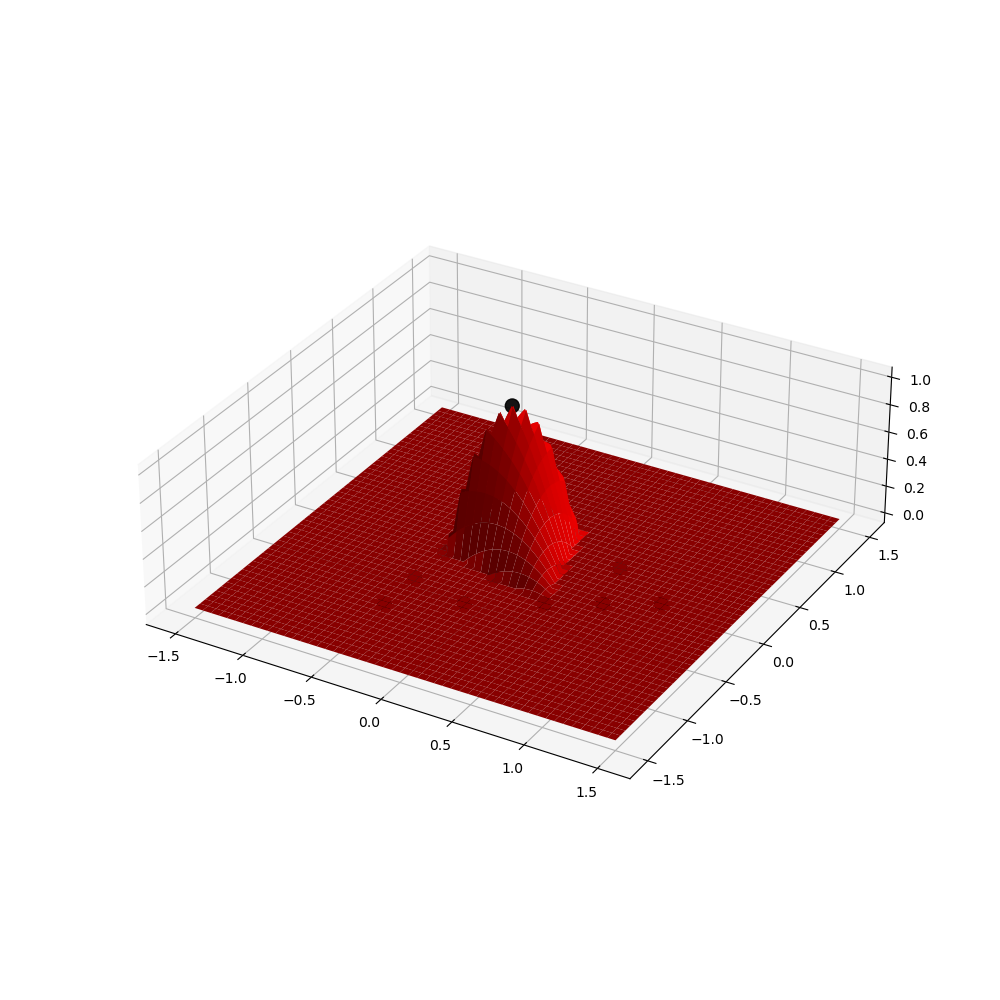

In [59]:
%matplotlib widget
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.plot_surface(mx, my, mz, color="red")
ax.set_box_aspect((np.ptp(mx), np.ptp(my), np.ptp(mz)))
ax.scatter3D(*points.T, fn_values[:, 0], s=100, color="black")
plt.show()

# Qubic interpolation

In [3]:
X = sympy.symbols("x1:9")
Y = sympy.symbols("y1:9")
Z = sympy.symbols("z1:9")

In [4]:
hex_sym = np.stack([X, Y, Z]).T

In [90]:
P, Q, R = sympy.symbols("P Q R")

In [8]:
hexa = symfem.create_element("hexahedron", "Lagrange", 1)
MAP = hexa.reference.get_map_to(hex_sym)

In [35]:
from sympy import solve
from sympy.abc import x, y, z

In [ ]:
solve([*MAP], [x, y, z], dict=True)